In [2]:
import torch
from torch import optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import imp
import time
import os
import itertools as it
import imp


import utils.movie_readin as mru
import utils.plotutils as plu
import utils.model as mod
import utils.dataset as vdataset
#import utils.model_analysis as man
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torchvideotransforms import video_transforms, volume_transforms


#torch.cuda.set_device(0)
cuda_device = ('cuda:0')

In [3]:
# movie parameters
frame_rate = 15
patch_size = 32
patch_seconds = 5
patch_frames = patch_seconds * frame_rate
movies_folder = '/data/vasha/duckmovie/ducks2_128_finalOut'

# model params
lambda_activations = [1., 100.]
lambda_biophysical = 0
conv_width = 10
num_hidden_nodes = [64]
noises = [0]

# training hyperparameters
num_epochs = 1000
batch_size = 5
learning_rates = [1e-4]
optimizer_types = ['adam']

#reporting parameters
print_epocs = 50

In [4]:
import imp
imp.reload(vdataset)
my_transforms = video_transforms.Compose([video_transforms.RandomCrop(patch_size)])

video_dataset = vdataset.VideoDataset(path=movies_folder, nframes=patch_frames, patch_size=patch_size, data_type='ducks', transform=None)
video_dataloader = DataLoader(video_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

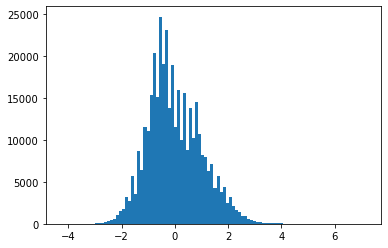

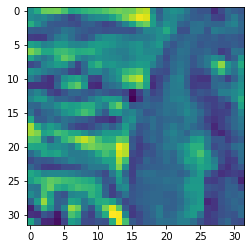

In [5]:
for j, video in enumerate(video_dataloader):
    frames = video['frames']
    break;
    
plt.hist(np.array(frames).flatten(),bins=100)
plt.show()
plt.imshow(np.array(frames[0,0,0,:,:]))

In [7]:
imp.reload(mod)

iterator = it.product(num_hidden_nodes, learning_rates, lambda_activations, optimizer_types, noises)
for iteration in iterator:
    num_hidden_node, learning_rate, lambda_activation, optimizer_type, noise = iteration
    compression = patch_size**2 / num_hidden_node
    print(f'Model:{patch_size}^2  = {patch_size**2} pixels by {conv_width} frames, to {num_hidden_node} hidden nodes for {compression}x compression')
    #record current param setting
    print(f'Optimizer:{optimizer_type}; Conv Width:{conv_width}; Hidden Nodes:{num_hidden_node}; Lambda Act:{lambda_activation};Learning Rate:{learning_rate}; Batch Size:{batch_size}')        
    params = f'{optimizer_type}_conv{conv_width}_hn{num_hidden_node}_lact{lambda_activation}_lr{learning_rate}_bs{batch_size}_noise{noise}'
    save_folder = os.path.join('./output',params)
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    model = mod.AEC(num_hidden_node, conv_width, patch_size, lambda_activation, noise, cuda_device).to(cuda_device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    psnr_history = []
    for i, epoch in enumerate(range(num_epochs)):
        for j, video in enumerate(video_dataloader):
            frames = video['frames'].to(cuda_device)
            optimizer.zero_grad() #zero out our gradients
            acts = model.encode(frames)
            recon = model.decode(acts)
            loss = model.loss_func(frames, recon, acts)
            loss_history.append(loss)
            psnr = model.calc_psnr(recon.cpu().detach().numpy(), frames.cpu().detach().numpy())
            psnr_history.append(psnr)
            loss.backward()
            optimizer.step()

            if((j+1)%print_epocs==0):
                print(f'Epoch {i+1}/{num_epochs}')
                for name, parameter in model.named_parameters():
                    if(name in ['tconv.module.weight_v', 'tconv.weight_v']):
                        inw = np.array(parameter.cpu().squeeze().detach())
                    elif(name in ['tdeconv.module.weight', 'tdeconv.weight']):
                        outw = np.array(parameter.cpu().squeeze().detach())
                #plot weigghts
                p = plu.plot_temporal_weights(inw)
                plt.savefig(os.path.join(save_folder,f'inw_{params}_{round(i/num_epochs,2)}.png'))
                plt.show()
                p = plu.plot_temporal_weights(outw)
                plt.savefig(os.path.join(save_folder,f'outw_{params}_{round(i/num_epochs,2)}.png'))
                plt.show()
                #plot stats
                plt.figure(figsize=(30,5))
                plt.subplot(1,5,1)
                p = plt.hist(np.array(acts.cpu().squeeze().detach()).flatten(),bins=100)
                plt.title('Activations')
                plt.subplot(1,5,2)
                loss_evolution = [np.float(loss) for loss in loss_history]
                plt.plot(loss_evolution)
                plt.title('Loss Evolution')
                plt.subplot(1,5,3)
                psnr_evolution = [np.float(psnr) for psnr in psnr_history]
                plt.plot(psnr_evolution)
                plt.title('PSNR')
                plt.subplot(1,5,4)
                plt.imshow(frames[0,0,0,:,:].cpu().detach().numpy())
                plt.title('Input Frame')
                plt.subplot(1,5,5)
                plt.imshow(recon[0,0,0,:,:].cpu().detach().numpy())
                plt.title('Recon Frame')
                plt.savefig(os.path.join(save_folder,f'stats_{params}.png'))
                plt.show()
            else:
                print('*',end='')

Model:32^2  = 1024 pixels by 10 frames, to 64 hidden nodes for 16.0x compression
Optimizer:adam; Conv Width:10; Hidden Nodes:64; Lambda Act:1.0;Learning Rate:0.0001; Batch Size:5


NameError: name 'psnr_history' is not defined

In [ ]:
iterator = it.product(num_hidden_nodes, learning_rates, lambda_activations, optimizer_types, learning_momentums, noises)

for iteration in iterator:
    num_hidden_node, learning_rate, lambda_activation, optimizer_type, learning_momentum, noise = iteration
    compression = patch_size**2 / num_hidden_node
    print(f'Model:{patch_size}^2  = {patch_size**2} pixels by {patch_seconds} frames, to {num_hidden_node} hidden nodes for {compression}x compression')
    #record current param setting
    print(f'Optimizer:{optimizer_type}; Conv Width:{conv_width}; Hidden Nodes:{num_hidden_node}; Lambda Act:{lambda_activation};Learning Rate:{learning_rate}; Batch Size:{batch_size}; Momentum:{learning_momentum}')        
    params = f'{optimizer_type}_conv{conv_width}_hn{num_hidden_node}_lact{lambda_activation}_lr{learning_rate}_bs{batch_size}_mm{learning_momentum}_noise{noise}'
    save_folder = os.path.join('./output',params)
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)

    #define model
    model = mod.AEC(num_hidden_node, conv_width, patch_size, lambda_activation, noise)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        #print('Found GPU - Running Model on it.')
        model.cuda()

    #define optimizer
    if(optimizer_type == 'adam'):
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif(optimizer_type == 'sgd'):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_momentum)

    #train over epochs
    print(f'Training {num_epochs} Epochs. ',end="")
    printing_modulo = num_epochs/print_epocs
    loss_history = []
    snr_history = []

    for i in range(num_epochs):
        batches_start = np.arange(0,np.shape(movie_dataset)[0], batch_size)
        for bs in batches_start:
            movie_batch = torch.unsqueeze(torch.tensor(movie_dataset[bs:bs+batch_size]),1).cuda()          
            optimizer.zero_grad() #zero out our gradients
            acts = model.encode(movie_batch)
            recon_batch = model.decode(acts)
            loss = model.loss_func(movie_batch, recon_batch, acts)
            loss.backward()
            optimizer.step()
            end = time.time()
            times.append(end-start)
            # record loss and snr after each epoch
            loss_history.append(loss.item())
            snr_history.append(model.calc_psnr(movie_batch.cpu.cdetach(), recon_batch).detach())
        # if it's our first iteration, give an estimate of time
        if(i==0):
            plt.clf()
            print(f'Estimated run time: {round(times[-1]*num_epochs/60,1)}mins.')
        elif((i+1)%printing_modulo==0):
            print(f'Epoch {i+1}/{num_epochs} (mean time per epoch: {round(np.mean(times),1)}s)')
            for name, parameter in model.named_parameters():
                if(name in ['tconv.module.weight_v', 'tconv.weight_v']):
                    inw = np.array(parameter.cpu().squeeze().detach())
                elif(name in ['tdeconv.module.weight', 'tdeconv.weight']):
                    outw = np.array(parameter.cpu().squeeze().detach())
            p = plt.hist(np.mean(np.array(acts.cpu().squeeze().detach()),axis=(0,2)))
            p = plu.plot_temporal_weights(inw)
            plt.savefig(os.path.join(save_folder,f'inw_{params}_{round(i/num_epochs,2)}.png'))
            plt.show()
            p = plu.plot_temporal_weights(outw)
            plt.savefig(os.path.join(save_folder,f'outw_{params}_{round(i/num_epochs,2)}.png'))
            plt.show()
            loss_evolution = [np.float(loss) for loss in loss_history]
            plt.plot(loss_evolution)
            plt.title('Loss Evolution')
            plt.savefig(os.path.join(save_folder,f'loss_evolution_{params}.png'))
            plt.show()
        else:
            print('*',end='')

    #get final weights & losses
    for name, parameter in model.named_parameters():
        if(name in ['tconv.module.weight_v', 'tconv.weight_v']):
            inw = np.array(parameter.cpu().squeeze().detach())
        elif(name in ['tdeconv.module.weight', 'tdeconv.weight']):
            outw = np.array(parameter.cpu().squeeze().detach())
    loss_evolution = [np.float(loss) for loss in loss_history]
    snr_evolution =  [np.float(snr) for snr in snr_history]

    # plot everything
    p = plu.plot_temporal_weights(inw)
    plt.savefig(os.path.join(save_folder,f'final_inw_{params}.png'))
    plt.clf()
    p = plu.plot_temporal_weights(outw)
    plt.savefig(os.path.join(save_folder,f'final_outw_{params}.png'))
    plt.clf()
    plt.plot(loss_evolution)
    plt.title('Loss Evolution')
    plt.savefig(os.path.join(save_folder,f'final_loss_{params}.png'))
    plt.clf()
    plt.plot(np.log(loss_evolution))
    plt.title('Log Loss Evolution')
    plt.savefig(os.path.join(save_folder,f'final_lgloss_{params}.png'))
    plt.clf()
    p = plt.plot(snr_evolution)
    plt.title('SNR Evolution')
    plt.savefig(os.path.join(save_folder,f'final_snr_{params}.png'))
    plt.clf()
    plt.figure()
    for i in range(10):
        plu.plot_movies_recons(np.squeeze(movie_batch), np.squeeze(recon_batch), i)
    plt.savefig(os.path.join(save_folder,f'finaol_recons_{params}.png'))



    print('Finished this Parameter')

print('Finished Sweep!!!')

In [ ]:
loss_evolution = [loss for loss in loss_history]
plt.plot(loss_evolution)
plt.show()
plt.plot(np.log(loss_evolution))
plt.show()
plt.plot(np.log(snr_history))
plt.show()

In [ ]:
p = plu.plot_temporal_weights(inw)
p = plu.plot_temporal_weights(outw)

In [ ]:
tiw = inw * 10
plu.plot_temporal_weights(tiw)

In [ ]:
plt.hist(tiw.flatten(),bins=500);

In [ ]:
plt.hist(inw.flatten(),bins=500);

In [ ]:
plt.hist(outw.flatten(),bins=500);

In [ ]:
movie_dataset.shape

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def debug_memory():
    import collections, gc, torch
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in sorted(tensors.items()):
        print('{}\t{}'.format(*line))
debug_memory()



In [ ]:
for name, parameter in model.named_parameters():
    print(name)
    if(name in ['tconv.module.weight_v', 'tconv.weight_v']):
        inw = np.array(parameter.squeeze().detach().cpu())
    elif(name in ['tdeconv.module.weight', 'tdeconv.weight']):
        outw = np.array(parameter.squeeze().detach().cpu())
    #elif(name=='tconv.weight_g'):
    #    print(np.shape(np.array(parameter.squeeze().detach())))

#print(inw.shape)
#print(bias.shape)
#print(wnorm.shape)
#print(outw.shape)
p = plu.plot_temporal_weights(inw)
p = plu.plot_temporal_weights(outw)

In [ ]:
plt.hist(inw.flatten())
plt.hist(outw.flatten())

In [ ]:
imp.reload(plu)
#movies = movie_batch[0]
#recons = recon_batch[0]
print('Movies:')
for i in range(10):
    plu.plot_movies_recons(np.squeeze(movie_batch), np.squeeze(recon_batch), i)
    #plt.colorbar()
plt.show()


In [ ]:
outw

In [ ]:
print(inw.shape)
print(np.max(inw))
print(np.min(inw))
for i in range(inw.shape[1]):
    plt.imshow(inw[9,i,:,:],cmap='Greys_r')
    plt.show()

In [ ]:
print(movie.shape)
m = movie[7,0,1,:,:]
plt.imshow(m)
print(m)

In [ ]:
movie.shape

In [ ]:
if(False):
    moreepochs = 2000
    print(f'Training for {moreepochs} more Epochs:')
    for i in range(moreepochs):
        start = time.time()
        times = []
        for movie in train_loader:
            movie = torch.unsqueeze(movie,1)
            #print(movie.size())
            movie = movie.float().cuda()
            optimizer.zero_grad()
            acts = model.encode(movie)
            recon = model.decode(acts)
            loss = loss_func(movie, recon, acts)
            loss_history.append(loss.detach())
            loss.backward()
            optimizer.step()
            end=time.time()
            times.append(end-start)
            
        if((i+1)%printing_modulo==0):
            print(f'{i+1}th Epoch (mean time per epoch: {round(np.mean(times))}s)')
        else:
            print('*',end='')

    print('Done!')

In [ ]:
def visualize_aec():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.encode(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Recon Images')


visualize_aec()
plt.ioff()
plt.show()

In [ ]:
torchvision.utils.make_grid(input_tensor)

In [ ]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

    
    
for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

In [ ]:
torch.cuda.empty_cache()
model = 'a'

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    

In [ ]:
model = AEC()
if torch.cuda.is_available():
    model.cuda()